In [22]:
from Modeling import model
from mygp import gp, kernel
import numpy as np
import batman 
import warnings
import matplotlib.pyplot as pl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pl.style.use('seaborn-deep')

import warnings
warnings.simplefilter('ignore')

import sys
sys.path.insert(0, '/Users/tgordon/research/libra/')
from libra import ObservationArchive, nirspec_pixel_wavelengths
import corner

In [23]:
# plotting function 

def plot_samples(data, t, title=None, mean_func=None, mean_params=None):
    fig, axs = pl.subplots(1, 2, figsize=(20, 6))
    fig.set_facecolor('white')
    
    for d in data:
        axs[0].plot(t, d, 'o')
    
    for d in data:
        axs[1].plot(t, d/np.median(d), 'o')
        
    if title is not None:
        pl.suptitle(title)
    axs[0].set_xlabel('time (JD)')
    axs[1].set_xlabel('time (JD)')
    axs[0].set_ylabel('flux')
    axs[1].set_ylabel('normalized flux')
    
    if mean_func is not None:
        axs[0].plot(t, mean_func(t, 0, *mean_params))
        
# transit model 

def transit(t, log_off, b, rp, t0, dt):
    
    t = np.array(t)
    T0 = dt*np.sqrt(1-b**2)/(1 - b**2 + rp)
    
    params = batman.TransitParams()
    params.t0 = t0                       
    params.per = 100                      
    params.rp = rp                      
    params.a = params.per/(T0*np.pi)                       
    params.inc = np.arccos(b/params.a)*(180/np.pi)                     
    params.ecc = 0.                      
    params.w = 90. 
    
    u1, u2 = 0.1, 0.3
    d4 = -u2
    d2 = u1 + 2*u2
    d1, d3 = 0, 0
    
    params.u = [u1, u2]                
    params.limb_dark = "quadratic" 
    
    #print(T0, params.per, params.inc, params.a)
    m = batman.TransitModel(params, t)    
    return log_off*m.light_curve(params)

def gauss(t, log_off, _, amp, t0, sig):
    return log_off*amp*np.exp(-((t0-t)**2)/(2*sig))

remove_offset = lambda d: d - np.median(d)

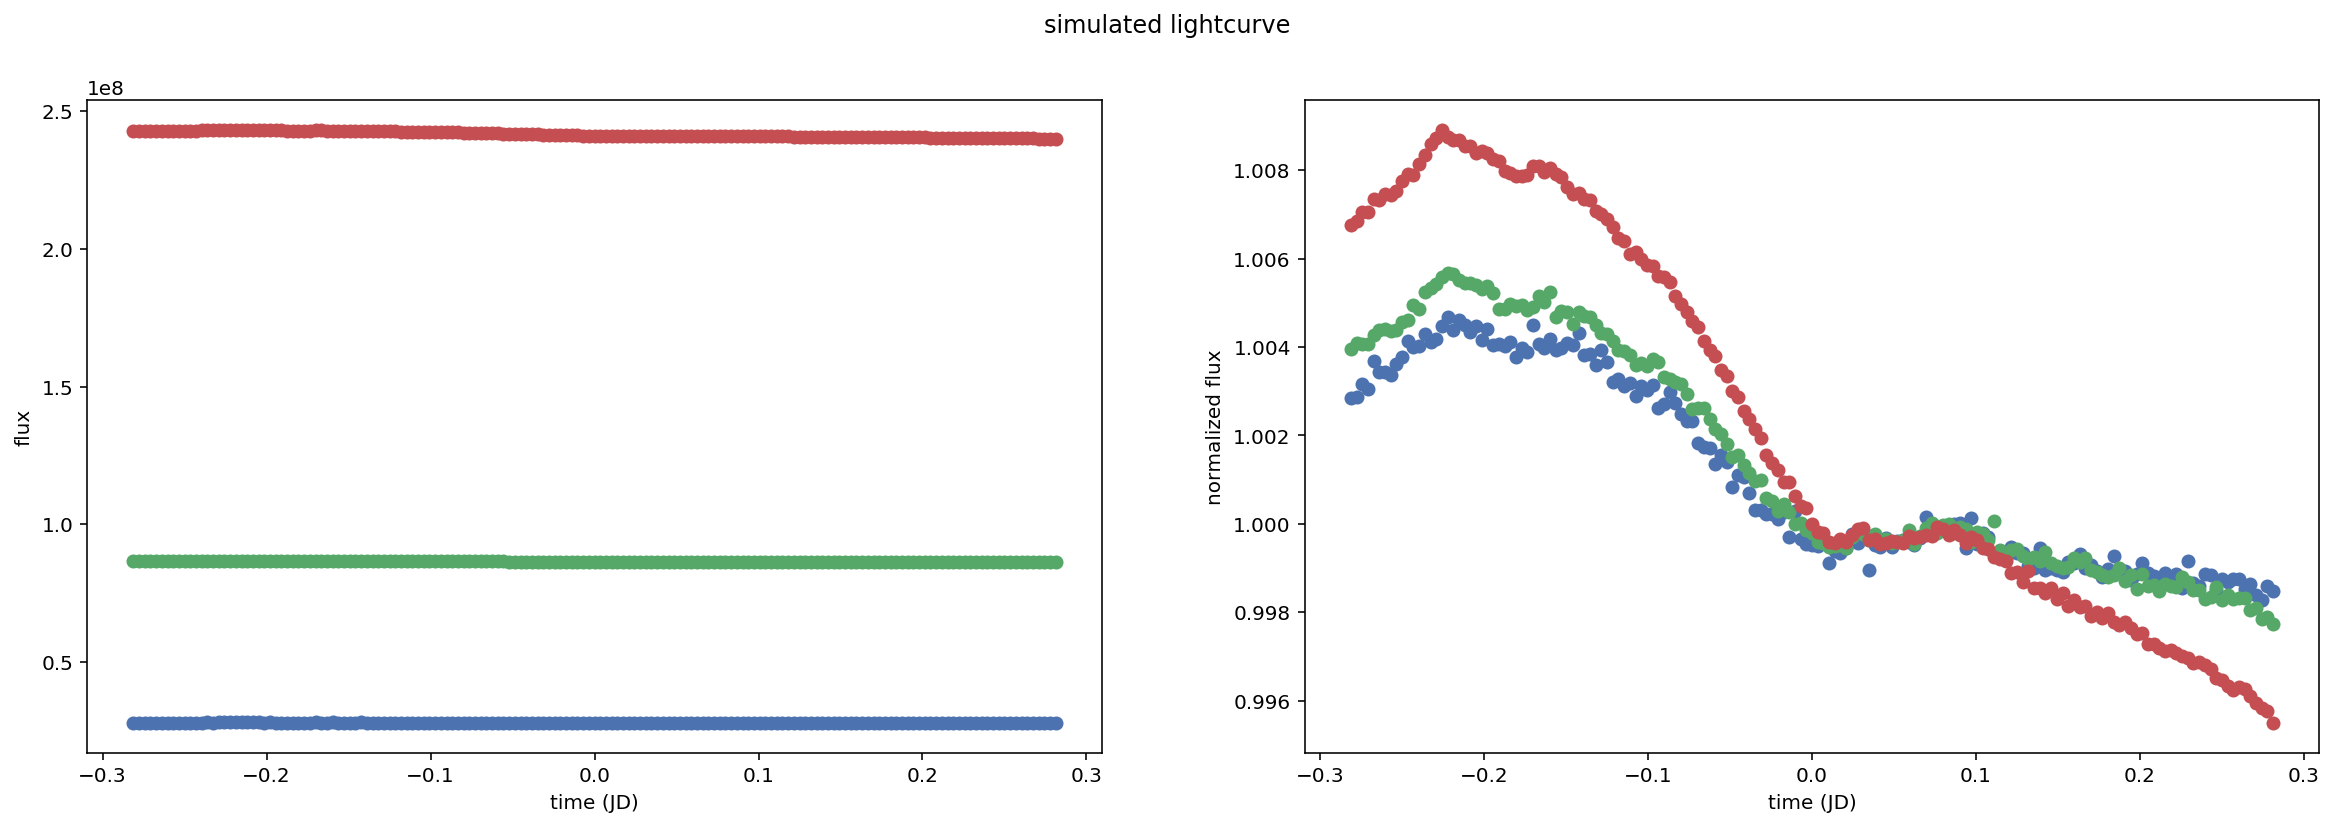

In [38]:
# get and plot data

basedir = '/Users/tgordon/research/libra/notebooks/'
data = np.loadtxt(basedir + 'tyler0_b_binned_small.txt')
t = data[0] - np.median(data[0])

figure = pl.figure(figsize=(12, 10))
data = data[::-1]
data = data[:-1]

plot_samples(data, t, 'simulated lightcurve')

#t = np.linspace(-0.3, 0.3, 100)

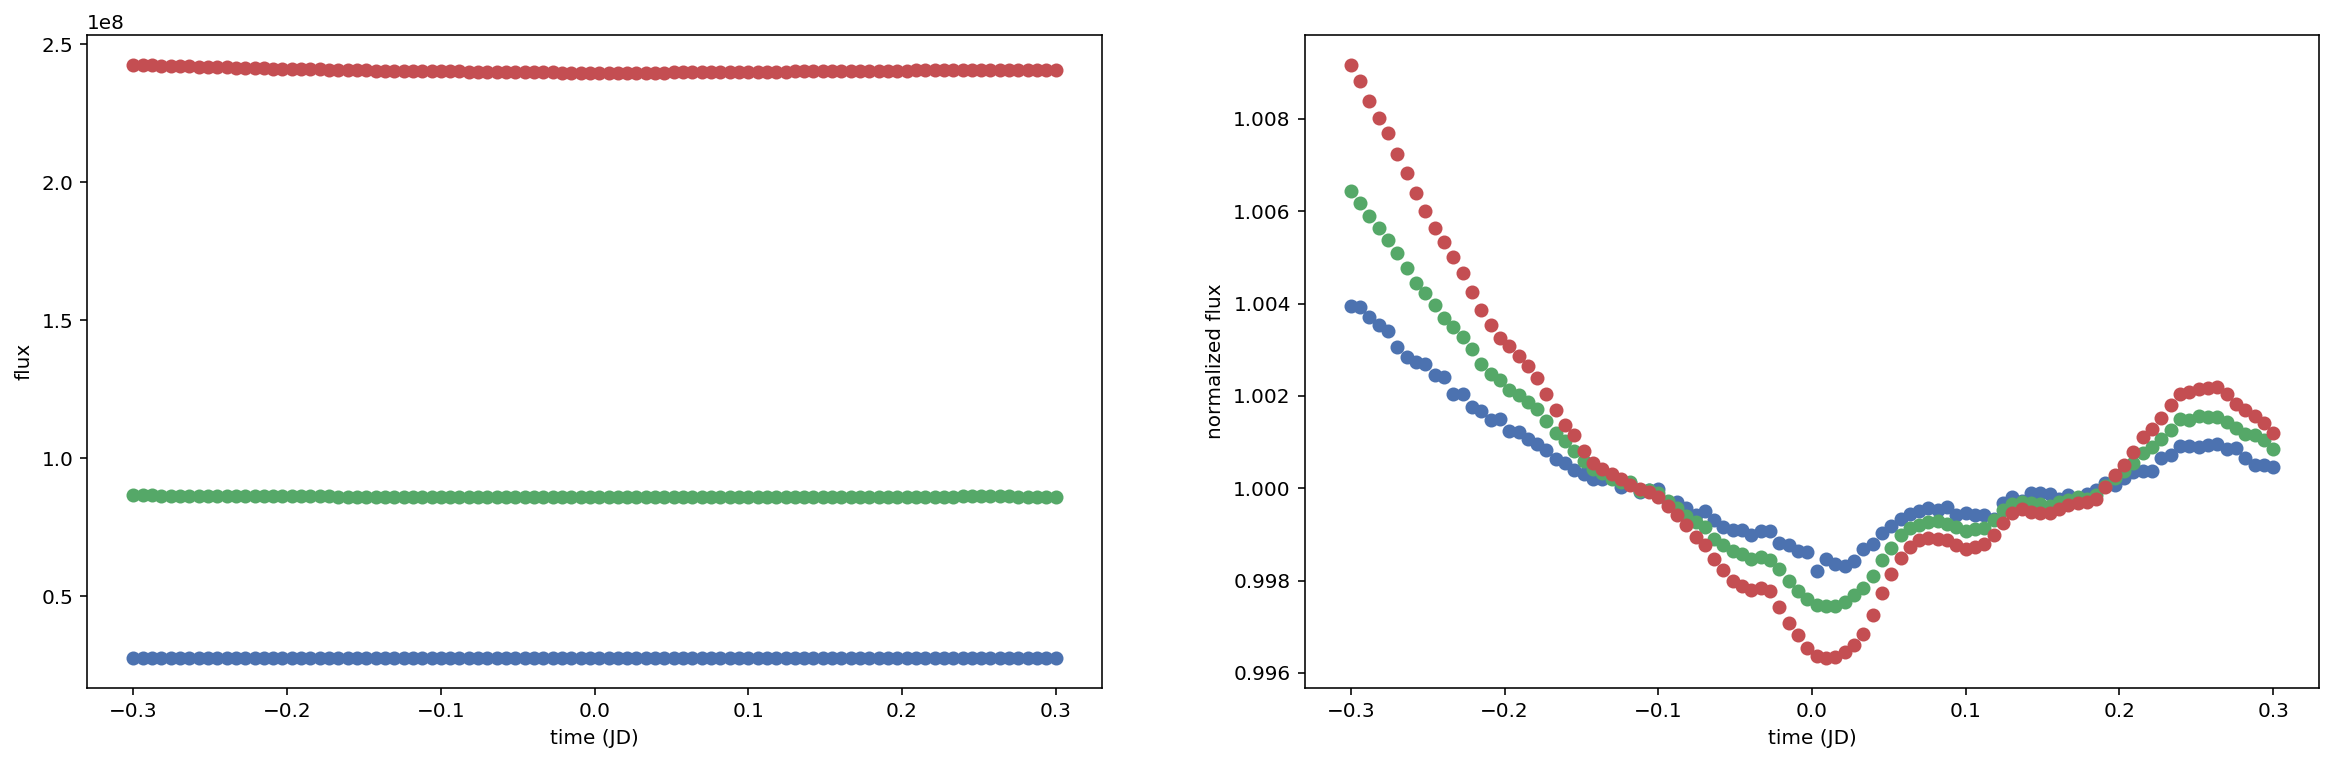

In [36]:
k1_params = [0.2, 5e9]
k2_params = [5, 20]
white_noise = [2e3]*3
offsets = [np.median(data[0]), np.median(data[1]), np.median(data[2])]
mean_params = [0.0, 0.0, 0.0, 0.1]

transit_model = model(k1_params, k2_params, white_noise, mean_params, offsets, transit, 
                        kernel.celerite_root2_kernel, kernel.scale_kernel, 3)

plot_samples(transit_model.sample(t), t)

In [39]:
transit_model.fit_variability(data, t, method='L-BFGS-B')

(array([-2.41056275, 22.5195315 ,  1.33788879,  2.88290237,  8.94638329,
        10.30622073,  8.1745267 , 17.14017033, 18.27415072, 19.30322912]),
 5665.030294152592)

k1_params:  [8.97647655e-02 6.02709819e+09]
k2_params:  [ 3.81098921 17.86605183]
mean_params:  [0.  0.  0.  0.1]
white_noise:  [ 7680.06503653 29918.15405461  3549.37461128]
offsets:  [2.77895423e+07 8.63699796e+07 2.41705146e+08]


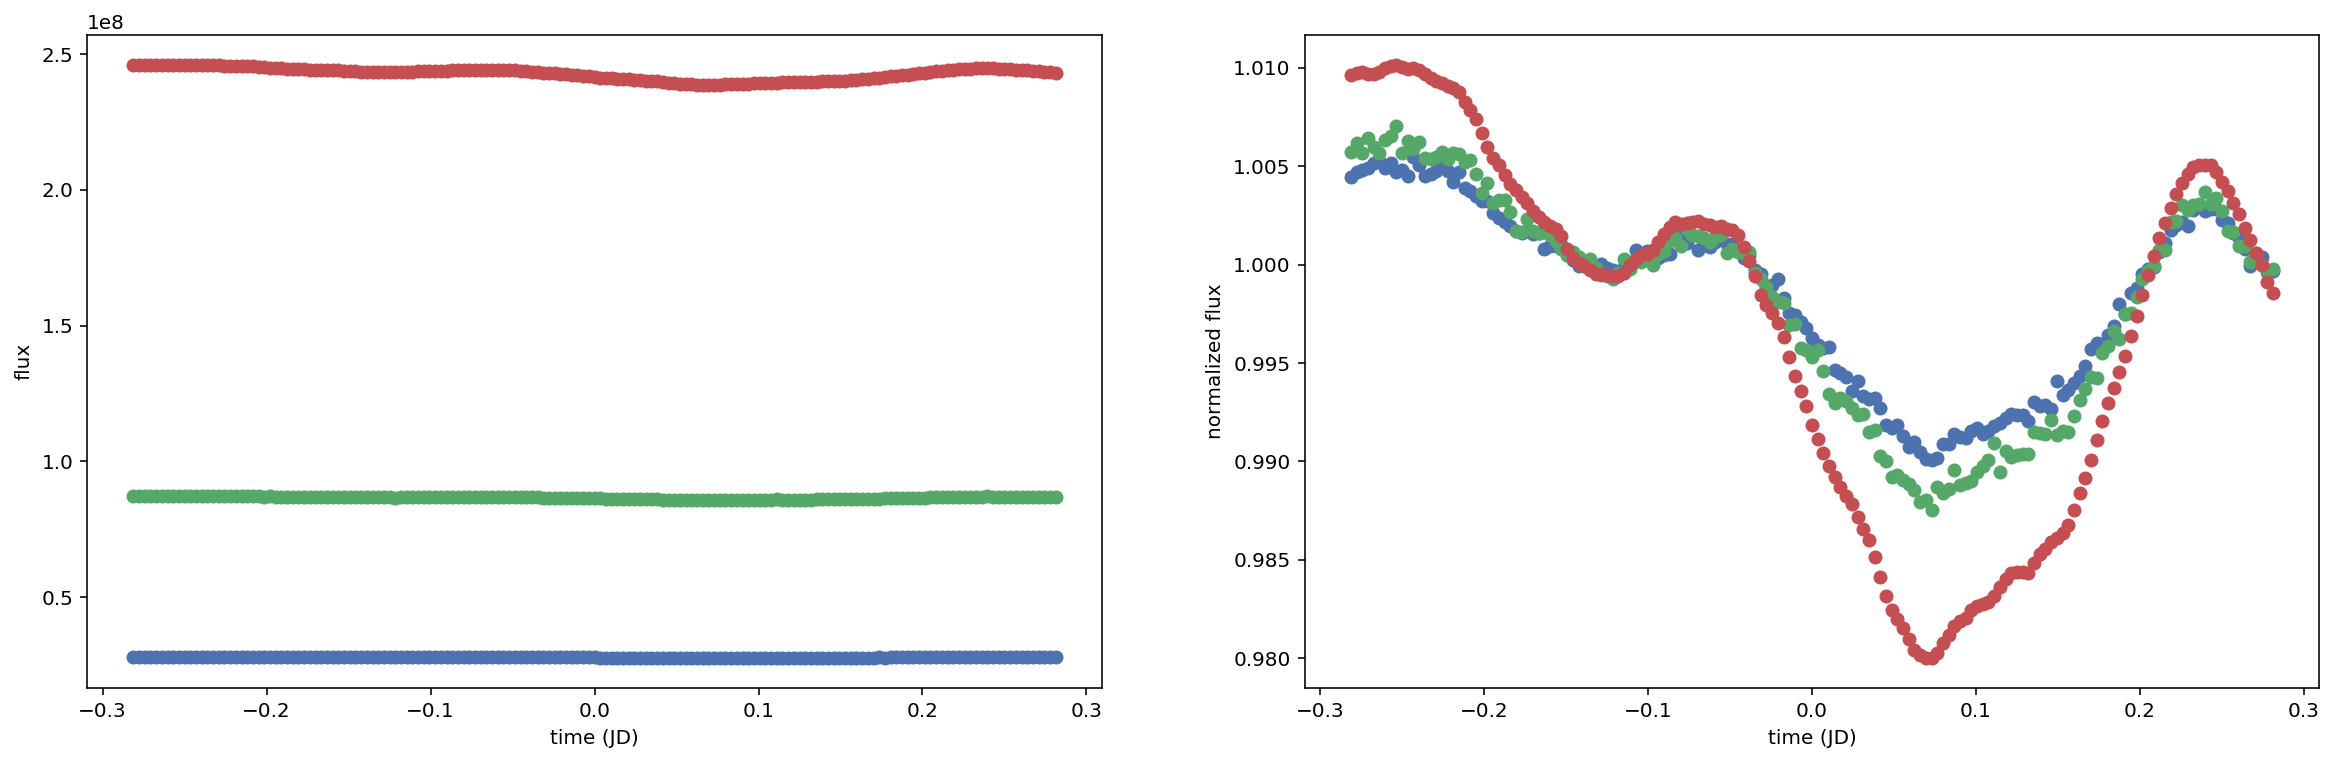

In [40]:
transit_model.print_params()
plot_samples(transit_model.sample(t), t)

In [41]:
n = 20
tau = np.linspace(0.01, 0.3, n)
amp = np.logspace(8, 12, n)

like = np.zeros((n, n))
for i, l in enumerate(tau):
    for j, a in enumerate(amp):
        transit_model.update_gp(k1_params = [l, a])
        transit_model.gp.compute(t)
        like[i][j] = transit_model.gp.log_likelihood(data, t)

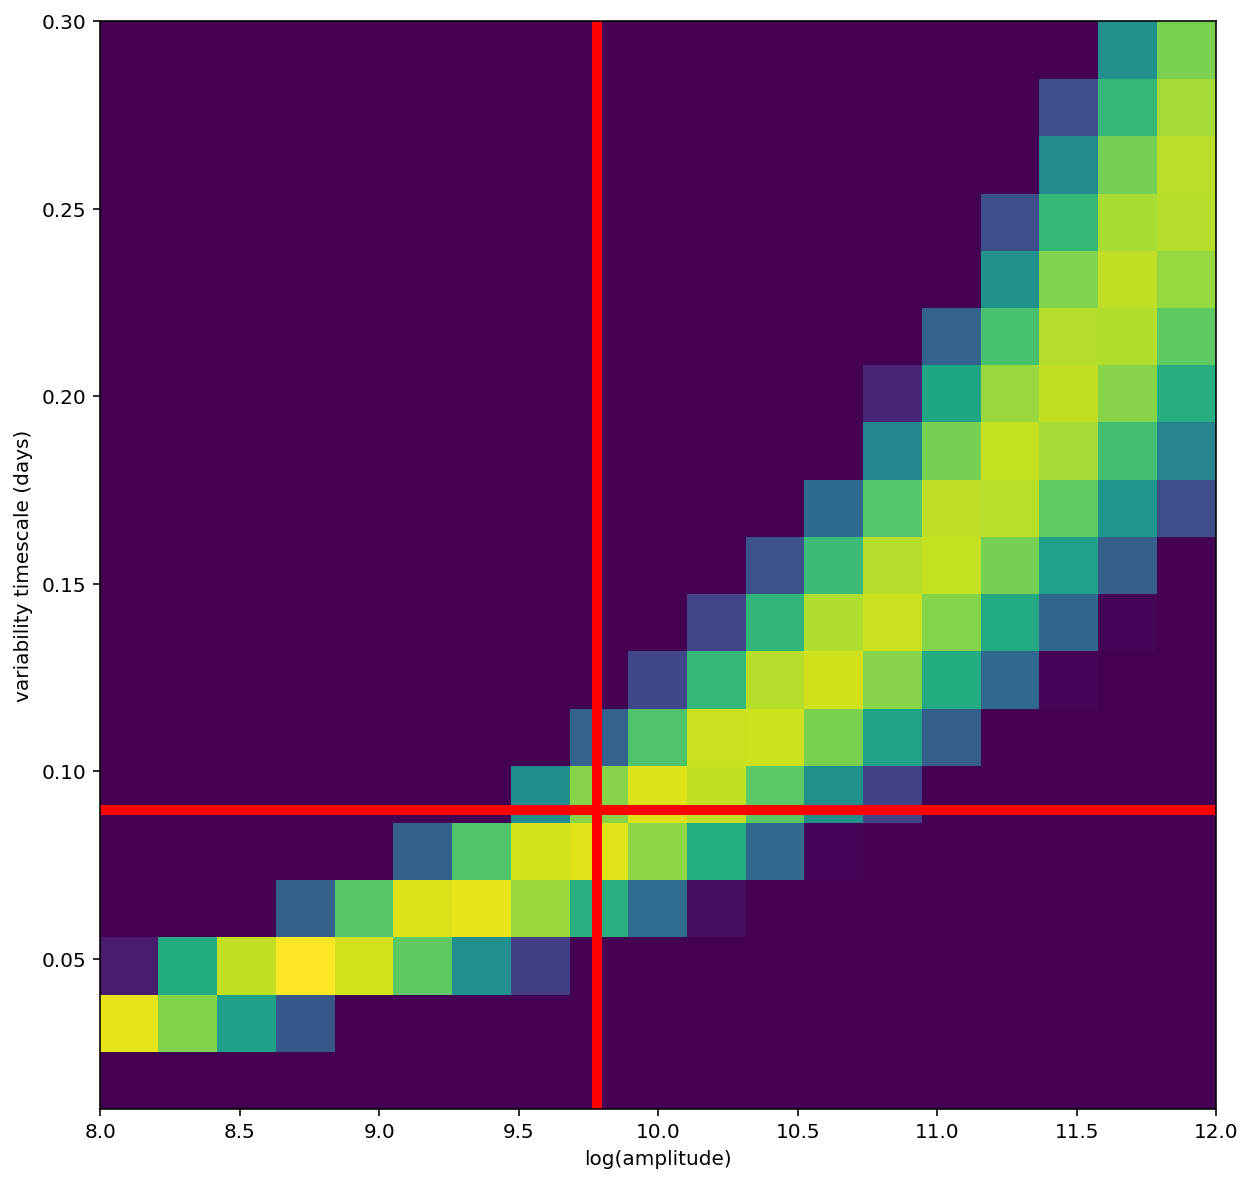

In [46]:
fig = pl.figure(figsize=(10, 10))
pl.pcolormesh(np.log10(amp), tau, like, vmin=np.max(like)-100)
pl.xlabel('log(amplitude)')
pl.ylabel('variability timescale (days)')

# actual
#pl.axvline(np.log10(3e11), color='w', linewidth=5)
#pl.axhline(0.2, color='w', linewidth=5)

# optimization results
pl.axvline(np.log10(6.02709819e+09), color='r', linewidth=5)
pl.axhline(8.97647655e-02, color='r', linewidth=5)